<a href="https://colab.research.google.com/github/yogeshgajjar/CNN-CIFAR-10-image-classification/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *CIFAR-10 on modified LeNet-5 CNN architecture using PyTorch* 


In [1]:
import sys
sys.version

'3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]'

# Import PyTorch

In [0]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.transforms as transforms 
import torchvision
import torch.optim as optim
import matplotlib.style as style
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import warnings 
import time 
from torch.autograd import Variable
warnings.filterwarnings('ignore')

# Initialize Hyper-parameters

In [0]:
batch_size = 4
learning_rate = 0.0001
epoch_range = 15
weight_decay = 0
dropout = True
xavier = False

trainLoss = []
testLoss = []
trainAccuracy = []
trainEpoch = []
testAccuracy = []

# Download CIFAR-10 dataset 

**Note:** We shuffle the loading process of `traindataset` to make the learning process independent of data order, but the order of `test_set` remains so as to examine whether we can handle unspecified bias order of inputs.

In [4]:
transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

traindataset= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)
train_set = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testdataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar)
test_set = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Build the Convolutional Neural Network derived from LeNet-5

## Convolution Neural Network Neural Network Model Structure
The CNN includes two convolution layer, two max-pooling layer and three fully-connected layers (i.e. fullyc1, fullyc2 & fullyc3) and a non-linear ReLU layer in between. 

In [0]:
class modelCIFAR(nn.Module):
    def __init__(self):
        super(modelCIFAR, self).__init__()
        self.convLayer1 = nn.Conv2d(3, 32, 5)             # First conv layer (3(input), 32(output), 5(filter_size))
        self.maxPool = nn.MaxPool2d(2, 2)                 # Max Pool (2(filter_size), 2(stride))
        self.convLayer2 = nn.Conv2d(32, 64, 5)            # Second conv layer (32(input), 64(output), 5(filter_size))
        self.drop1 = nn.Dropout(0.2, inplace=False)       # Dropout layer with probability 0.2 
        self.fullyc1 = nn.Linear(1600, 200)               # Fully Connected Layer (64*5*5(input), 200(output))
        self.xav = nn.init.xavier_normal_(self.fullyc1.weight)
        self.fullyc2 = nn.Linear(200, 100)                # Fully Connected Layer (200(input), 100(output))
        self.fullyc3 = nn.Linear(100, 10)                 # Fully Connected Layer (100(input), 10(output))
        

    def forward(self, img):
        img = self.maxPool(self.drop1(F.relu(self.convLayer1(img))))
        img = self.maxPool(self.drop1(F.relu(self.convLayer2(img))))
        # img = self.maxPool(F.relu(self.convLayer1(img)))
        # img = self.maxPool(F.relu(self.convLayer2(img)))
        img = img.view(-1, 64 * 5 * 5)
        img = F.relu(self.fullyc1(img))
        img = F.relu(self.fullyc2(img))
        img = self.fullyc3(img)
        return img   

# Instantiate the FNN

We now create a real CNN based on our structure.

In [0]:
cifar = modelCIFAR()

# Enable GPU
**Note:** You could enable this line to run the codes on GPU

In [0]:
use_cuda = True

In [0]:
if use_cuda and torch.cuda.is_available():
  cifar.cuda()

# Choose the Loss Function and Optimizer

Loss function (criterion) decides how the output can be compared to a class, which determines how good or bad the neural network performs. And the optimizer chooses a way to update the weight in order to converge to find the best weights in this neural network.

In [0]:
#'ASGD': optim.ASGD(cifar.parameters(), lr)} 
#'Adam': optim.Adam(cifar.parameters(), lr)
#'SGD': optim.SGD(cifar.parameters(), lr, momentum=0.9)

optimizer_dict = {'SGD': optim.SGD(cifar.parameters(), lr=learning_rate, momentum=0.9)}
                  # 'Adam': optim.Adam(cifar.parameters(), lr=learning_rate, weight_decay=weight_decay), 
                  # 'ASGD': optim.ASGD(cifar.parameters(), lr=learning_rate, weight_decay=weight_decay)} 
# optimizer_dict = {'Adam': optim.Adam(cifar.parameters(), lr=learning_rate, weight_decay=weight_decay)}
# optimizer_dict = {'ASGD': optim.ASGD(cifar.parameters(), lr=learning_rate, weight_decay=weight_decay)}
criterion = nn.CrossEntropyLoss()

# Training the CNN Model

This process might take around 15 to 45 minutes depending on your machine. 

In [0]:
def train_CIFAR():
    for epoch in range(epoch_range): 
        runningLoss = 0.0
        trAcc = 0.0
        totTrain = 0
        start_time = time.time()
        for i, data in enumerate(train_set, 0):
            inputTrain, labelTrain = data
            inputTrain = Variable(inputTrain)
            labelTrain = Variable(labelTrain)

            if use_cuda and torch.cuda.is_available():
              inputTrain = inputTrain.cuda()
              labelTrain = labelTrain.cuda()


            optimizer.zero_grad()
            outputTrain = cifar(inputTrain)
            loss = criterion(outputTrain, labelTrain)
            loss.backward()
            optimizer.step()

            runningLoss += loss.item()
            trainEpoch.append(loss.item())

            totTrain += 1  
            _, pred = torch.max(outputTrain, dim=1)
            correct_train = pred.eq(labelTrain.data.view_as(pred))
            accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
            trAcc += accuracy_train.item()


        with torch.no_grad():
            corr, test_l = test_CIFAR_1(cifar, test_set)

        trainLoss.append(runningLoss/totTrain)
        testLoss.append(test_l/len(testdataset))
        trainAccuracy.append(trAcc/totTrain)
        testAccuracy.append(corr/len(testdataset))

        print("Epoch: {}/{} |".format(epoch+1, epoch_range), 
              "Train loss: %.3f |" % (runningLoss/totTrain),
              "Train Accuracy: %.3f |" % (100*trAcc/totTrain),
              "Test loss: %.3f |" % (test_l/len(testdataset)),
              "Test Accuracy: %.3f |" % (100*corr/len(testdataset)),
              "Time/Epoch: %.3f sec|" % (time.time() - start_time))

        runningLoss = 0.0
        trAcc = 0.0
    print('Finished Training')
    print_CIFAR(trainAccuracy, testAccuracy, trainLoss, testLoss, key, trainEpoch)


# Testing the CNN Model
Similar to training the neural network, we also need to load batches of test images and collect the outputs. This is used to calculate the test while the model is training. We call this method in the training method above. 

In [0]:
def test_CIFAR_1(cifar, test_set):
    correcTest = 0
    testLoss = 0.0
    for data in test_set:
        imageTest, labelTest = data

        if use_cuda and torch.cuda.is_available():
          imageTest = imageTest.cuda()
          labelTest = labelTest.cuda()

        outputTest = cifar(imageTest)
        testLoss += criterion(outputTest, labelTest).item()

        _, predicted_test = torch.max(outputTest.data, 1)
        correcTest += (predicted_test == labelTest).sum().item()


    return correcTest, testLoss

# Plotting the CNN performance 

Plotting the epoch - accuracy, epoch - loss and epoch - performance plots in training and testing phase seperately. 

In [0]:
def mean(li): return sum(li)/len(li)

def print_CIFAR(trainAccuracy, testAccuracy, trainLoss, testLoss, key, trainEpoch):
    plt.figure(1, figsize=(10,6))
    plt.plot(trainAccuracy, label='Train Accuracy', color='red', marker='o', linewidth=2)
    plt.plot(testAccuracy, label='Test Accuracy', color='blue', marker='x', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epoch Accuracy Plot \n Dropout: "+str(dropout)+"| Learning Rate: "+str(learning_rate)+"| Optimizers: "+key+
              " | Weight Decay:"+str(weight_decay)+"| Batch Size: "+str(batch_size)+"| Filter Weight(xavier_normal): "+str(xavier))
    plt.legend()
    plt.savefig('acc'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')

    plt.figure(2, figsize=(10,6))
    plt.plot(trainLoss, label='Train loss', color='r', marker='o', linewidth=2)
    plt.plot(testLoss, label='Test loss', color='b', marker='x', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    # plt.title("Loss plots")
    plt.title("Epoch Loss Plot \n Dropout: "+str(dropout)+"| Learning Rate: "+str(learning_rate)+"| Optimizers: "+key+
              " | Weight Decay: "+str(weight_decay)+"| Batch Size: "+str(batch_size)+"| Filter Weight(xavier_normal): "+str(xavier))
    plt.legend()
    plt.savefig('loss'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')
    
    plt.figure(3, figsize=(12,4))
    plt.plot([mean(trainEpoch[i:i+500]) for i in range(len(trainEpoch)-50)])
    plt.xlabel('training batch-size')
    plt.ylabel('loss')
    plt.title("Performance Curve \n Dropout: "+str(dropout)+"| Learning Rate: "+str(learning_rate)+"| Optimizers: "+key+
              " | Weight Decay: "+str(weight_decay)+"| Batch Size: "+str(batch_size)+"| Filter Weight(xavier_normal): "+str(xavier))
    plt.savefig('per'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg',dpi=100, bbox_inches='tight')
    
    # plt.show()

# Running the final model


Epoch: 1/15 | Train loss: 1.979 | Train Accuracy: 28.074 | Test loss: 0.418 | Test Accuracy: 39.510 | Time/Epoch: 60.158 sec|
Epoch: 2/15 | Train loss: 1.527 | Train Accuracy: 44.546 | Test loss: 0.353 | Test Accuracy: 48.870 | Time/Epoch: 60.009 sec|
Epoch: 3/15 | Train loss: 1.359 | Train Accuracy: 50.944 | Test loss: 0.331 | Test Accuracy: 52.370 | Time/Epoch: 57.921 sec|
Epoch: 4/15 | Train loss: 1.251 | Train Accuracy: 55.218 | Test loss: 0.302 | Test Accuracy: 56.810 | Time/Epoch: 57.051 sec|
Epoch: 5/15 | Train loss: 1.155 | Train Accuracy: 58.916 | Test loss: 0.283 | Test Accuracy: 60.080 | Time/Epoch: 56.143 sec|
Epoch: 6/15 | Train loss: 1.075 | Train Accuracy: 61.898 | Test loss: 0.273 | Test Accuracy: 60.890 | Time/Epoch: 55.395 sec|
Epoch: 7/15 | Train loss: 1.007 | Train Accuracy: 64.456 | Test loss: 0.266 | Test Accuracy: 62.530 | Time/Epoch: 55.341 sec|
Epoch: 8/15 | Train loss: 0.946 | Train Accuracy: 66.912 | Test loss: 0.242 | Test Accuracy: 66.100 | Time/Epoch: 56.2

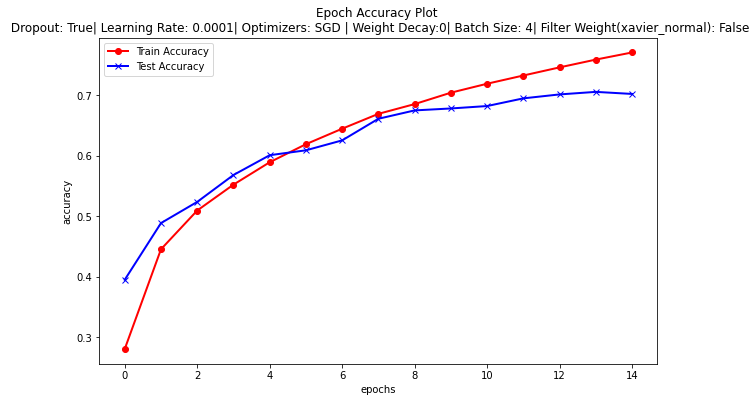

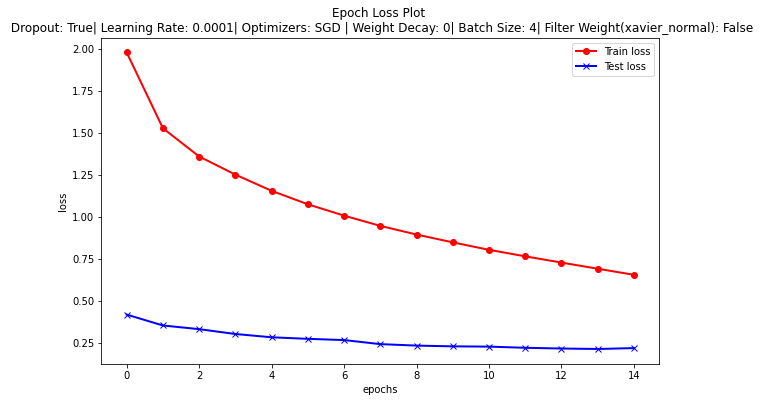

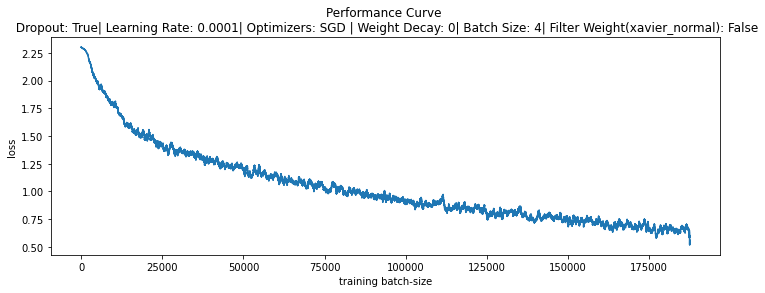

In [13]:
for key,value in optimizer_dict.items():
    optimizer = value;
    train_CIFAR()
    

In [0]:
PATH = './cifar_net'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.pth'
torch.save(cifar.state_dict(), PATH)
